In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange

from cvx.covariance.trading_model import *
from cvx.covariance.utils import *
from cvx.covariance.ewma import ewma_mean, ewma_cov, iterated_ewma
from cvx.covariance.covariance_combination import CovarianceCombination
sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [2]:
returns = pd.read_csv('../data/SP500_top25_adjusted.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

# Covariance predictors

In [3]:
# Rolling window 
rw = rolling_window(returns, 250) 

In [4]:
# EWMA
ewma_125 = dict(ewma_cov(returns, halflife=125))

In [5]:
# IEWMA  
iewma_63_125 = iterated_ewma(returns, vola_halflife=63, cov_halflife=125) 

Next we import the precomputed MGARCH predictors (computed using the rmgarch
package in R). We used the first 250 days for training. Hence the first
predictors is given at day 250, and predicts the covariance matrix for day 251.
(Python uses zero-based indexing, so the first predictor will have time index 249.)

In [6]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r due to numerical issues 

mgarch_cond_cov = pd.read_csv("../mgarch_predictors_from_R/stocks/mgarch_stocks_adj.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = returns.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

In [7]:
# CM-IEWMA
pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)]
Sigmas = {f"{pair[0]}-{pair[1]}": iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63) for pair in pairs}
Sigmas["10-21"] = regularize_covariance(Sigmas["10-21"], lamda=0.05)

results = list(CovarianceCombination(Sigmas=Sigmas, returns=returns).solve_window(window=10, verbose=True))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

100%|██████████| 3138/3138 [00:36<00:00, 86.03it/s] 


In [8]:
# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    prescient[t] = pd.DataFrame(cov, index=returns.columns, columns=returns.columns)

# Define end and start dates for backtests

In [9]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2011-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [10]:
names = ["RW-250", "EWMA-125", "IEWMA-63-125", "MGARCH", "CM-IEWMA", "PRESCIENT"]

predictors_temp = [rw, ewma_125, iewma_63_125, mgarch, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# CM-IEWMA component weights

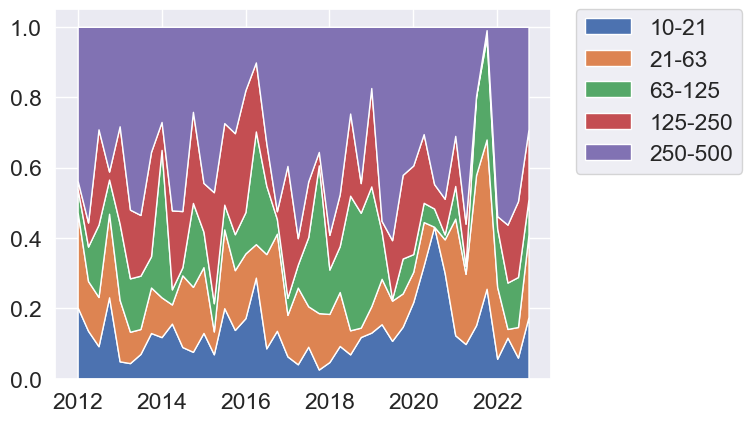

In [11]:
quarterly_weights  = pd.DataFrame(weights).T.resample("Q").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=["10-21", "21-63", "63-125", "125-250", "250-500"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

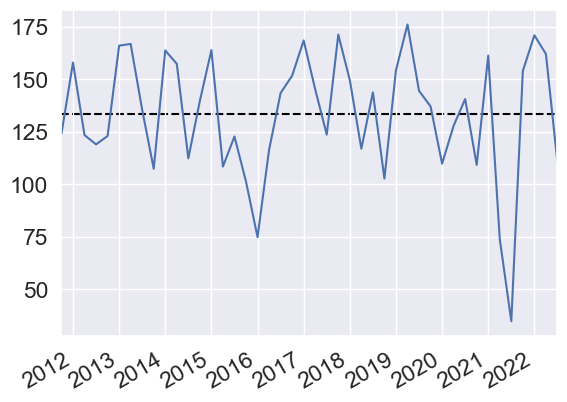

In [12]:
halflifes_vola = np.array([10, 21, 63, 125, 250])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()

# Log likelihoods

In [13]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing RW-250 log-likelihood...
Computing EWMA-125 log-likelihood...
Computing IEWMA-63-125 log-likelihood...
Computing MGARCH log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing PRESCIENT log-likelihood...


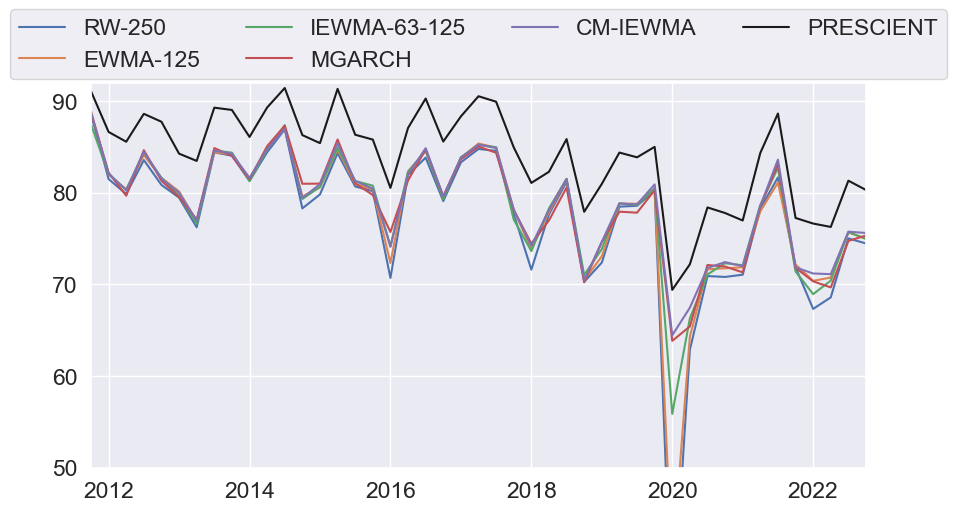

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(50,92);

# Regrets

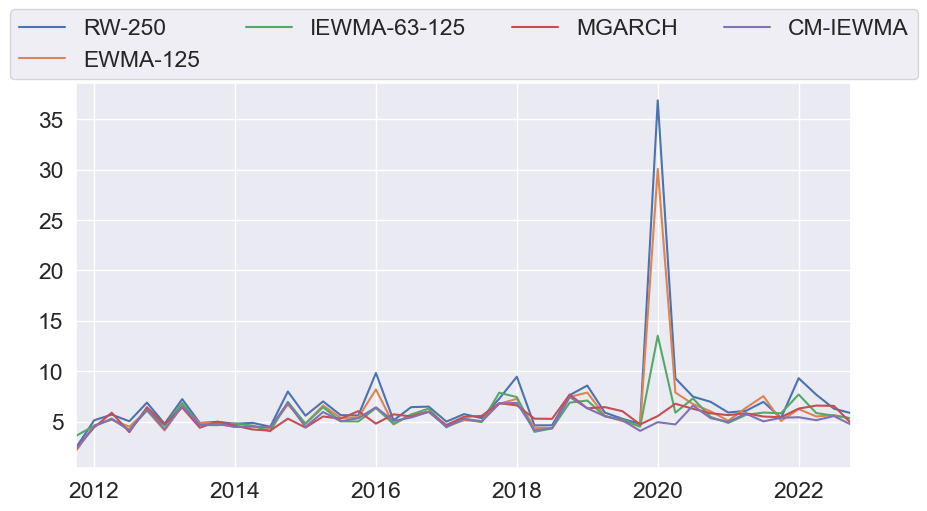

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);


### Compare CM-IEWMA with MGARCH

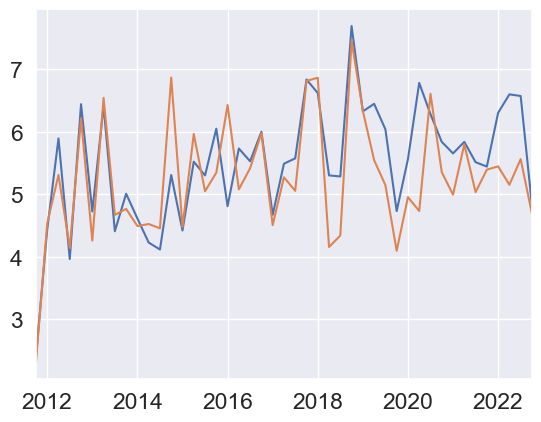

In [16]:
regret_mgarch = regrets["MGARCH"].resample("Q").mean()
regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()

regret_mgarch.plot(label="MGARCH")
regret_cm_iewma.plot(label="CM-IEWMA");
# plt.legend();

In [17]:
cm_iewma_advantage = (regret_cm_iewma - regret_mgarch < 0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 71% of the time


### Regret CDF plots

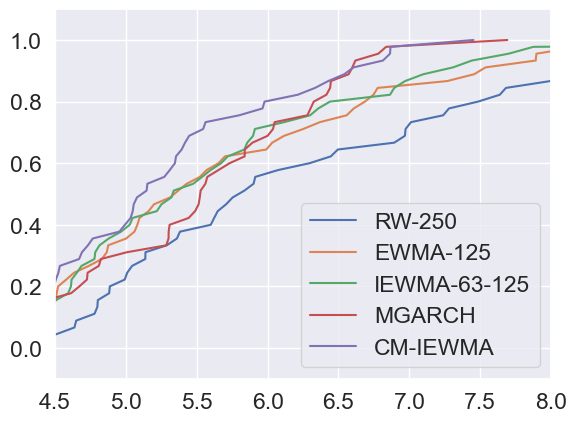

In [102]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(4.5,8)
plt.ylim(-0.1,1.1)
plt.legend();

### Regret metrics

In [101]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   RW-250 & 6.9 & 4.8 & 36.9 \\
   EWMA-125 & 6.1 & 3.8 & 30.1 \\
   IEWMA-63-125 & 5.7 & 1.6 & 13.5 \\
   MGARCH & 5.5 & 1.0 & 7.7 \\
   CM-IEWMA & 5.2 & 0.9 & 7.5 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


In [19]:
### Metrics
print("(Mean, Std, Max)")

for name in regrets:
    print("\n", name)

    if name!="PRESCIENT":
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print(metrics)
    else:
        print((0.0, 0.0, 0.0, 0.0, 0.0, 0.0))

(Mean, Std, Max)

 RW-250
(6.9, 4.8, 36.9)

 EWMA-125
(6.1, 3.8, 30.1)

 IEWMA-63-125
(5.7, 1.6, 13.5)

 MGARCH
(5.5, 1.0, 7.7)

 CM-IEWMA
(5.2, 0.9, 7.5)

 PRESCIENT
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)


# Portfolio optimization

In [20]:
# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio constraints
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}

# Volatility target
sigma_tar = 0.1
excess = True

### Equally weighted

In [21]:
from cvx.covariance.trading_model import *
adjust_factor = 1
traders_eq_w = {}
for i in trange(len(predictors)):
    predictor = predictors[i]
    returns_temp = returns.loc[start_date:end_date].shift(-1).dropna()
    Sigmas_temp = {time: predictor[time] for time in returns_temp.index}
    trader = Trader(returns_temp, Sigmas_temp)
    trader.backtest(portfolio_type="eq_weighted", adjust_factor=adjust_factor) 
    traders_eq_w[names[i]] = trader

100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


In [89]:
metrics_eq_w = {}
for name, trader in traders_eq_w.items():
    metrics_eq_w[name] = trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)
create_table(metrics_eq_w)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 6.1\% & 10.5\% & 0.6 & 23\% \\
   EWMA-125 & 5.9\% & 9.9\% & 0.6 & 22\% \\
   IEWMA-63-125 & 6.2\% & 10.0\% & 0.6 & 20\% \\
   MGARCH & 6.6\% & 9.3\% & 0.7 & 16\% \\
   CM-IEWMA & 6.5\% & 9.5\% & 0.7 & 17\% \\
   \hline
   PRESCIENT & 11.7\% & 9.9\% & 1.2 & 10\% \\
   \bottomrule
\end{tabular}


### Minimum risk

In [29]:
from cvx.covariance.trading_model import *
traders_min_risk = {}
for i in trange(len(predictors)):
    predictor = predictors[i]
    returns_temp = returns.loc[start_date:end_date].shift(-1).dropna()
    Sigmas_temp = {time: predictor[time] for time in returns_temp.index}
    trader = Trader(returns_temp, Sigmas_temp)
    trader.backtest(portfolio_type="min_risk", adjust_factor=adjust_factor, additonal_cons=additonal_cons)
    traders_min_risk[names[i]] = trader

  0%|          | 0/6 [00:00<?, ?it/s]

Adding additional constraints


 17%|█▋        | 1/6 [00:08<00:44,  8.84s/it]

Adding additional constraints


 33%|███▎      | 2/6 [00:16<00:33,  8.41s/it]

Adding additional constraints


 50%|█████     | 3/6 [00:25<00:24,  8.32s/it]

Adding additional constraints


 67%|██████▋   | 4/6 [00:35<00:17,  8.95s/it]

Adding additional constraints


 83%|████████▎ | 5/6 [00:44<00:09,  9.27s/it]

Adding additional constraints


100%|██████████| 6/6 [00:55<00:00,  9.21s/it]


In [87]:
metrics_min_risk = {}
for name, trader in traders_min_risk.items():
    metrics_min_risk[name] = trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)
create_table(metrics_min_risk)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 9.7\% & 12.0\% & 0.8 & 23\% \\
   EWMA-125 & 8.9\% & 11.1\% & 0.8 & 20\% \\
   IEWMA-63-125 & 9.7\% & 11.3\% & 0.9 & 19\% \\
   MGARCH & 11.3\% & 12.3\% & 0.9 & 18\% \\
   CM-IEWMA & 9.1\% & 11.0\% & 0.8 & 15\% \\
   \hline
   PRESCIENT & 21.4\% & 10.1\% & 2.1 & 11\% \\
   \bottomrule
\end{tabular}


### Maximum diversification 

In [32]:
from cvx.covariance.trading_model import *
traders_max_diverse = {}
for i in trange(len(predictors)):
    predictor = predictors[i]
    returns_temp = returns.loc[start_date:end_date].shift(-1).dropna()
    Sigmas_temp = {time: predictor[time] for time in returns_temp.index}
    trader = Trader(returns_temp, Sigmas_temp)
    trader.backtest(portfolio_type="max_diverse", adjust_factor=adjust_factor, additonal_cons=additonal_cons)
    traders_max_diverse[names[i]] = trader

100%|██████████| 6/6 [00:46<00:00,  7.69s/it]


In [86]:
metrics_max_diverse = {}
for name, trader in traders_max_diverse.items():
    metrics_max_diverse[name] = trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)
create_table(metrics_max_diverse)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 8.4\% & 11.2\% & 0.8 & 22\% \\
   EWMA-125 & 7.9\% & 10.4\% & 0.8 & 21\% \\
   IEWMA-63-125 & 8.2\% & 10.4\% & 0.8 & 20\% \\
   MGARCH & 10.0\% & 9.8\% & 1.0 & 15\% \\
   CM-IEWMA & 8.8\% & 10.0\% & 0.9 & 16\% \\
   \hline
   PRESCIENT & 16.7\% & 10.0\% & 1.7 & 11\% \\
   \bottomrule
\end{tabular}


### Risk parity 

In [39]:
from cvx.covariance.trading_model import *
traders_risk_par = {}
for i in trange(len(predictors)):
    predictor = predictors[i]
    returns_temp = returns.loc[start_date:end_date].shift(-1).dropna()
    Sigmas_temp = {time: predictor[time] for time in returns_temp.index}
    trader = Trader(returns_temp, Sigmas_temp)
    trader.backtest(portfolio_type="risk_parity", adjust_factor=adjust_factor, additonal_cons=additonal_cons)
    traders_risk_par[names[i]] = trader

100%|██████████| 6/6 [00:54<00:00,  9.07s/it]


In [83]:
metrics_risk_par = {}
for name, trader in traders_risk_par.items():
    metrics_risk_par[name] = trader.get_metrics(diluted_with_cash=True, sigma_des=sigma_tar, rf=rf,\
        excess=excess)
create_table(metrics_risk_par)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 7.4\% & 10.8\% & 0.7 & 22\% \\
   EWMA-125 & 6.8\% & 10.1\% & 0.7 & 21\% \\
   IEWMA-63-125 & 7.2\% & 10.2\% & 0.7 & 20\% \\
   MGARCH & 7.9\% & 9.7\% & 0.8 & 15\% \\
   CM-IEWMA & 7.4\% & 9.7\% & 0.8 & 16\% \\
   \hline
   PRESCIENT & 15.4\% & 10.0\% & 1.5 & 9\% \\
   \bottomrule
\end{tabular}


### Mean variance

In [69]:
r_hat_ewma = pd.DataFrame(dict(ewma_mean(returns, halflife=63))).T.loc[start_date:end_date].iloc[:-1]
from cvx.covariance.trading_model import *
traders_mean_var = {}
for i in trange(len(predictors)):
    predictor = predictors[i]
    returns_temp = returns.loc[start_date:end_date].shift(-1).dropna()
    Sigmas_temp = {time: predictor[time] for time in returns_temp.index}
    trader = Trader(returns_temp, Sigmas_temp, r_hats=r_hat_ewma)
    trader.backtest(portfolio_type="mean_variance", adjust_factor=adjust_factor, additonal_cons=additonal_cons, sigma_des=sigma_tar)
    traders_mean_var[names[i]] = trader

100%|██████████| 6/6 [02:31<00:00, 25.23s/it]


In [85]:
metrics_mean_var = {}
for name, trader in traders_mean_var.items():
    metrics_mean_var[name] = trader.get_metrics(diluted_with_cash=False, rf=rf,\
            excess=excess)
create_table(metrics_mean_var)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW-250 & 2.9\% & 11.7\% & 0.2 & 27\% \\
   EWMA-125 & 2.6\% & 11.2\% & 0.2 & 25\% \\
   IEWMA-63-125 & 3.2\% & 10.9\% & 0.3 & 23\% \\
   MGARCH & 2.3\% & 11.1\% & 0.2 & 21\% \\
   CM-IEWMA & 3.5\% & 10.9\% & 0.3 & 19\% \\
   \hline
   PRESCIENT & 10.0\% & 9.8\% & 1.0 & 14\% \\
   \bottomrule
\end{tabular}
